In [1]:
# FINDSPARK
import findspark
findspark.init()

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# BASIC IMPORTS
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# PYSPARK
from pyspark.sql.functions import col, udf, explode, when, collect_list, size, mean
from pyspark.sql.column import Column, _to_java_column
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

from pyspark.sql import SparkSession
import pyspark as ps
config = ps.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g') # Increase the driver memory to avoid HeapOverflow when repartitioning.
sc = ps.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution.
spark = SparkSession(sc)

plt.style.use('ggplot')

In [2]:
PATH_ALL_METADATAS_SRC = '../data/generated/all_metadatas_en.parquet'

In [3]:
all_metadatas = spark.read.parquet(PATH_ALL_METADATAS_SRC)

In [4]:
all_metadatas.show(10)

+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
| display_id|             domains|domain_categories|is_sponsored|      categories|          channel_id|crawl_date|         description|dislike_count|duration|like_count|                tags|               title|upload_date|view_count|diff_month|
+-----------+--------------------+-----------------+------------+----------------+--------------------+----------+--------------------+-------------+--------+----------+--------------------+--------------------+-----------+----------+----------+
|---1Yr75DDo|[pond5.com, foota...|               []|       false|Film & Animation|UCarI394EclOjlRrm...|2019-11-18|http://www.pond5....|            2|      47|        11|free Chroma Key E...|Explosion 1 - gre...| 2012-07-14|      3708|        84|
|---SLoSKUoc|[pl

In [5]:
domain_categories_count = all_metadatas \
    .withColumn('domain_categories_count', size('domain_categories')) \
    .groupBy('domain_categories_count') \
    .count().orderBy('domain_categories_count', ascending=True) \
    .toPandas()

In [6]:
domain_categories_count['domain_categories_count'] += 0.001

In [7]:
domain_categories_count.head()

,domain_categories_count,count
0,0.001,28193007
1,1.001,6369092
2,2.001,838282
3,3.001,134564
4,4.001,23123


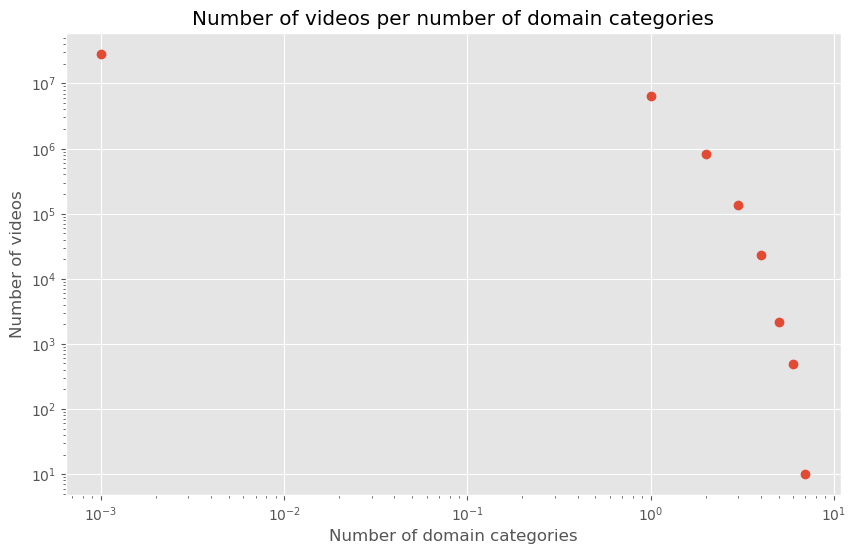

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(domain_categories_count['domain_categories_count'], domain_categories_count['count'], 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of domain categories')
plt.ylabel('Number of videos')
plt.title('Number of videos per number of domain categories')
plt.show()

The majority of videos are not classified as being sponsorized by our model, and a vast majority of sponsored videos tend to have only one sponsor. This analysis has also been supported by the network analysis since sponsor nodes were mostly isolated.

In [9]:
video_categories = all_metadatas \
    .where(col('is_sponsored')) \
    .where(col('categories') != '') \
    .withColumn('domain_category', explode('domain_categories')) \
    .groupby('categories', 'domain_category') \
    .count() \
    .orderBy('count', ascending=False) \
    .toPandas()

In [10]:
video_categories = video_categories.set_index('categories') \
    .pivot(columns='domain_category', values='count')

video_categories_count = video_categories \
    .sum(axis=1) \
    .sort_values(ascending=True) \
    .to_frame() \

video_categories_top = video_categories.apply(lambda x: x.sort_values(ascending=False).head(3), axis=1) \
    .reindex(video_categories.sum(axis=1).sort_values(ascending=True).index)

In [11]:
video_categories_top.head()

domain_category,Agency,Application,Beauty,Education,Media,Music,Service,Shop,Travel,Vehicle,Video Game
categories,,,,,,,,,,,
Nonprofits & Activism,2544.0,4484.0,NaN,1033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pets & Animals,13033.0,4340.0,NaN,NaN,NaN,NaN,4897.0,NaN,NaN,NaN,NaN
Travel & Events,13958.0,6739.0,NaN,NaN,NaN,NaN,NaN,NaN,9444.0,NaN,NaN
Comedy,23606.0,13762.0,NaN,NaN,NaN,NaN,NaN,9482.0,NaN,NaN,NaN
Autos & Vehicles,39403.0,NaN,NaN,NaN,NaN,NaN,NaN,16288.0,NaN,19282.0,NaN


In [12]:
video_categories_count.head()

,0
categories,
Nonprofits & Activism,11370.0
Pets & Animals,32568.0
Travel & Events,59107.0
Comedy,76355.0
Autos & Vehicles,109685.0


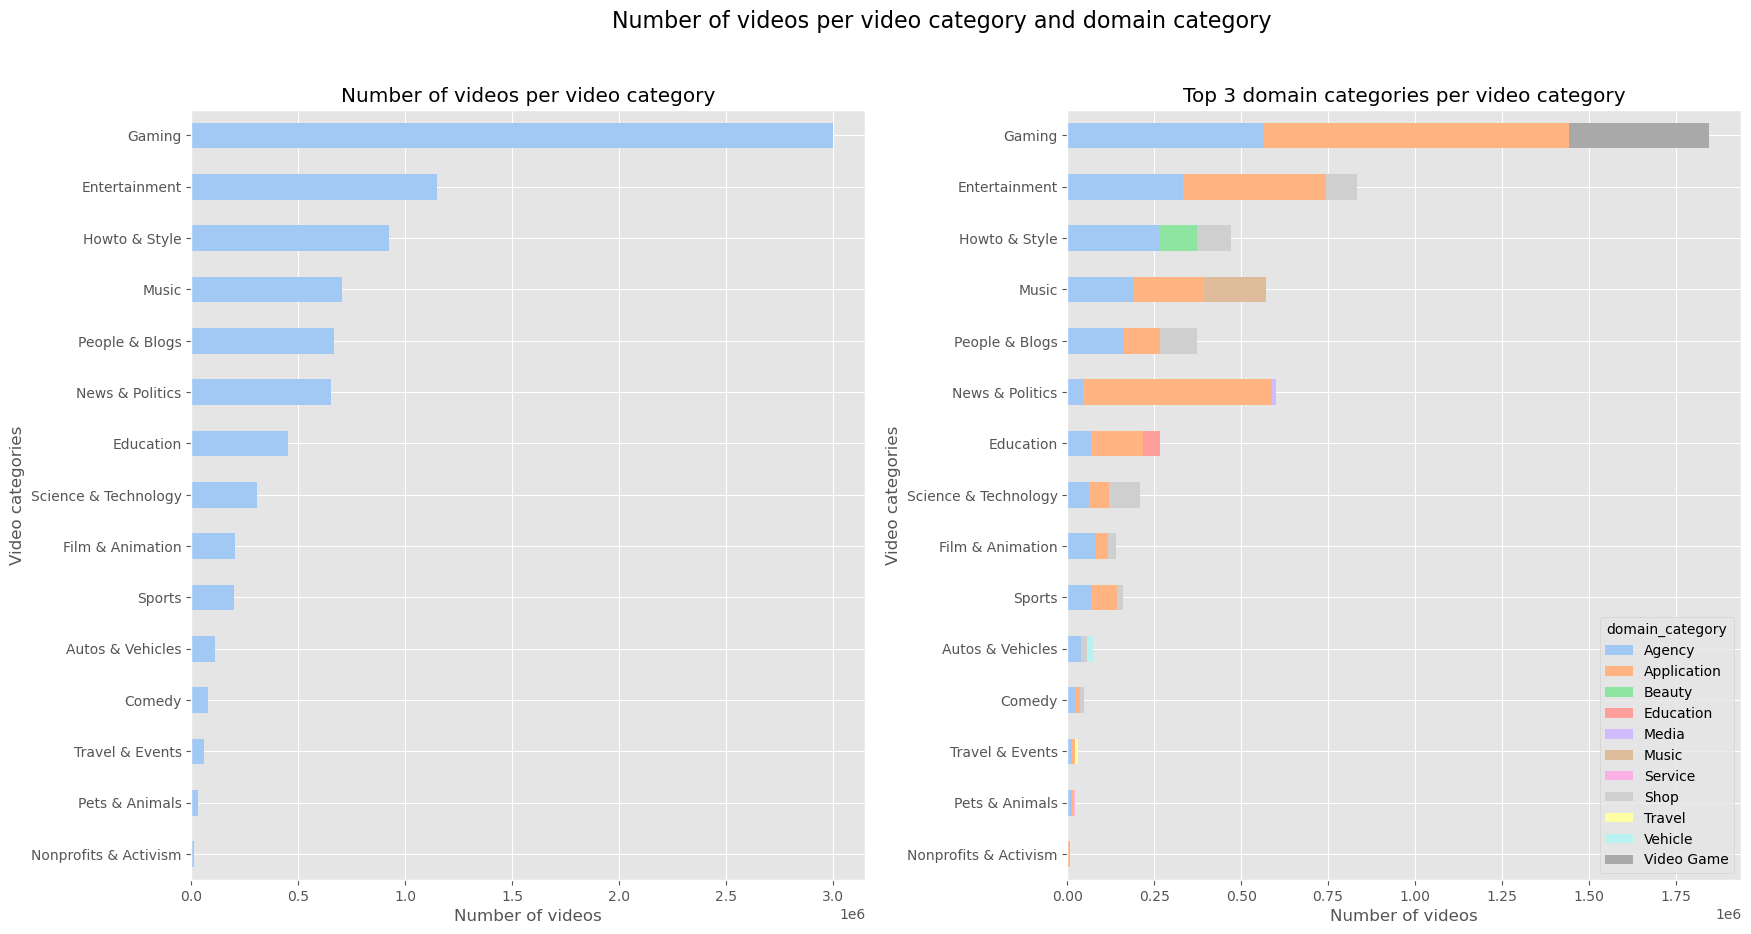

In [13]:
colors = sns.color_palette('pastel') + ['#A9A9A9']

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

video_categories_count.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlabel('Number of videos')
ax1.set_ylabel('Video categories')
ax1.set_title('Number of videos per video category')
ax1.get_legend().remove()

video_categories_top.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Number of videos')
ax2.set_ylabel('Video categories')
ax2.set_title('Top 3 domain categories per video category')

fig.suptitle('Number of videos per video category and domain category', fontsize=16)
fig.subplots_adjust(wspace=0.3)
plt.show()

The plot on the left shows us the number of sponsored videos per video category. We can see that `Gaming` is the most sponsored category of videos, followed by `Entertainment` and `Howto & Style`. 

The plot on the right shows us more information about the sponsor categories for each video category. Indeed, we can see that many videos are sponsored by `Applications` and all of them by `Agencies`. 
It is easy to spot that the video category and sponsor categories are related: the `Gaming` video category is mainly sponsored by `Video Game` sponsors which makes sense. `Entertainment` and `Howto & Style` are sponsored by `Shops`.

Also, `Howto & Style` and `People & Blogs` have suprisingly few sponsored videos on the second graph. This might indicate that these categories have a more diverse, uniform network of sponsors as many other categories not shown on this graph might be sponsoring them.

In [14]:
video_categories_total_count = all_metadatas \
    .select("categories") \
    .groupBy("categories") \
    .count() \
    .toPandas() \
    .set_index('categories') \
    .to_dict()['count']

In [15]:
video_categories_count_norm = video_categories_count \
    .apply(lambda x: x / video_categories_total_count[x.name], axis=1) \
    .sort_values(by=0, ascending=True)

In [16]:
video_categories_count_norm.head()

,0
categories,
Nonprofits & Activism,0.029495
Sports,0.101279
Autos & Vehicles,0.107100
Pets & Animals,0.132863
Travel & Events,0.133789


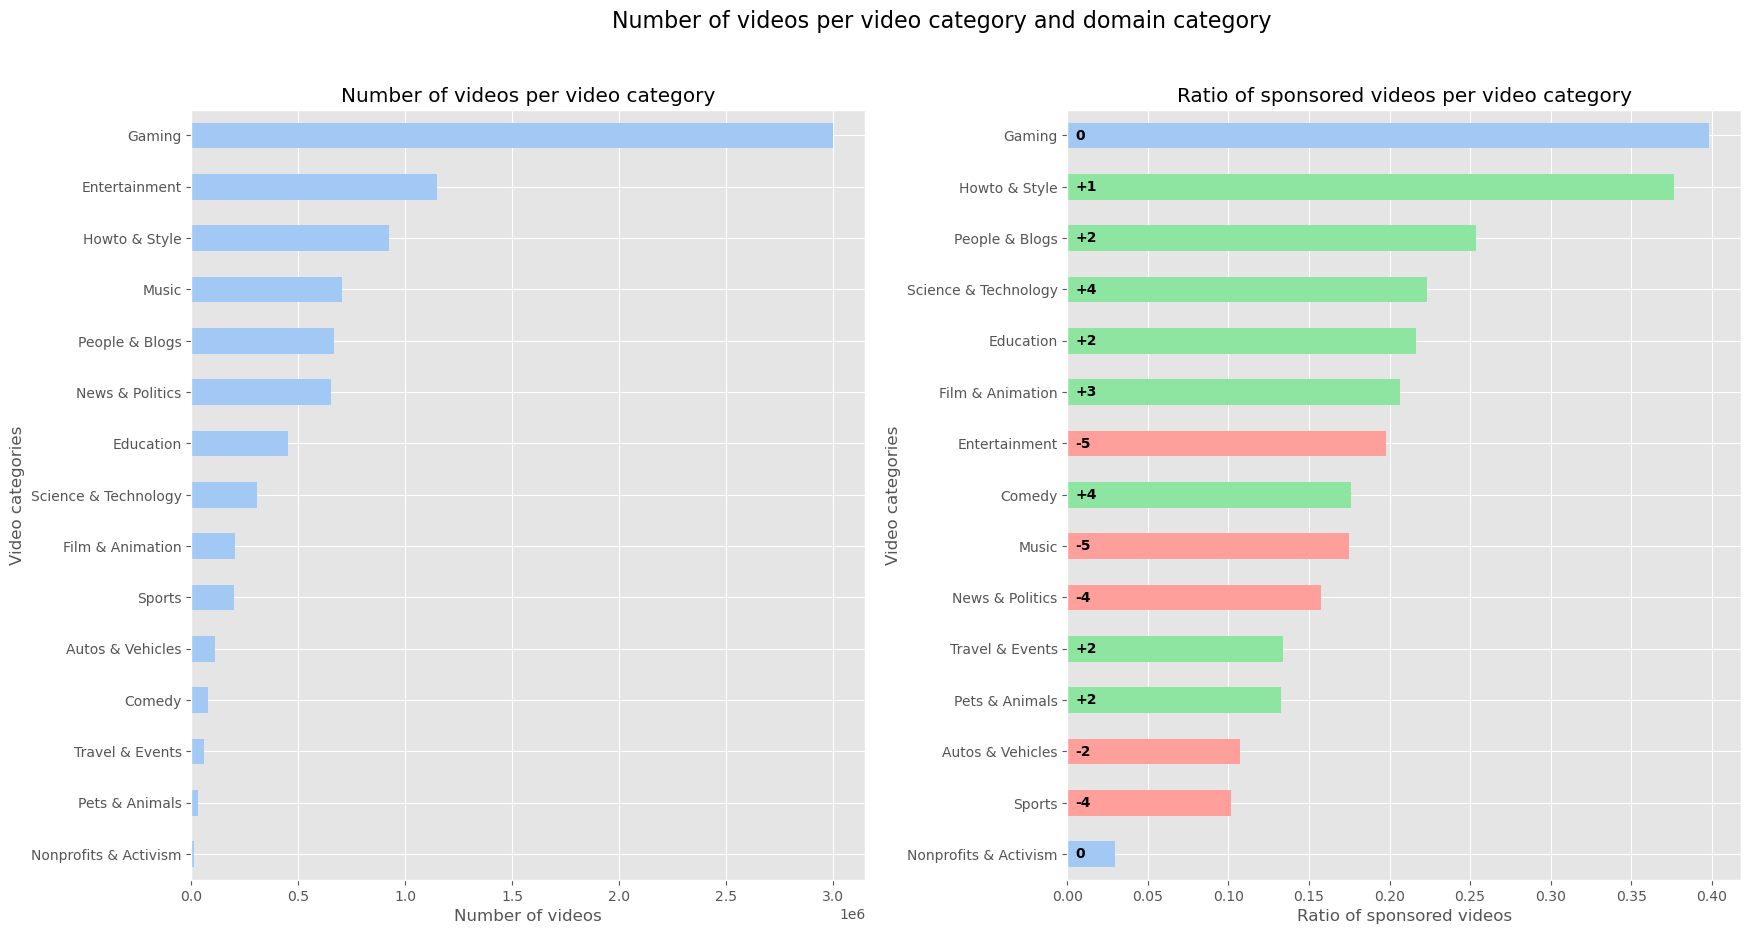

In [17]:
colors = sns.color_palette('pastel') + ['#A9A9A9']

# 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

video_categories_count.plot(kind='barh', stacked=True, color=colors, ax=ax1)
ax1.set_xlabel('Number of videos')
ax1.set_ylabel('Video categories')
ax1.set_title('Number of videos per video category')
ax1.get_legend().remove()

video_categories_count_norm.plot(kind='barh', stacked=True, color=colors, ax=ax2)
ax2.set_xlabel('Ratio of sponsored videos')
ax2.set_ylabel('Video categories')
ax2.set_title('Ratio of sponsored videos per video category')
ax2.get_legend().remove()

# Add ranking number of previous graph
ranking = video_categories_count[0].rank(ascending=False).astype(int).to_dict()
ranking_norm = video_categories_count_norm[0].rank(ascending=False).astype(int).to_dict()
for i, v in enumerate(video_categories_count_norm.index):
    diff = ranking[v] - ranking_norm[v]
    # Show difference between ranking
    ax2.text(0.005, i, '+'+str(diff) if diff > 0 else str(diff), color='black', va='center', fontweight='bold')
    # Change bar color depending on ranking difference
    if diff > 0:
        ax2.patches[i].set_facecolor(colors[2])
    elif diff < 0:
        ax2.patches[i].set_facecolor(colors[3])
    else:
        ax2.patches[i].set_facecolor(colors[0])

fig.suptitle('Number of videos per video category and domain category', fontsize=16)
fig.subplots_adjust(wspace=0.3)
plt.show()

The graph above shows a comparison on the number of videos per category and the ratio of sponsored videos per category. We can see that `Gaming` stays in the lead with about $40\%$ of sponsored videos. `Howto & Style` also has a high ratio of sponsored videos, but `Nonprofits & Activism` stays in the last position with very few sponsored videos.

The ratio of sponsored videos per category gives us better reasoning about the sponsorship of videos since categories are not equally represented in the dataset. We still get the same conclusion as before for some categories such as `Gaming` and `Nonprofits & Activism`, but some categories such as `Howto & Style` and `Science & Technology` come out as more sponsored than `Entertainment` and `Music`, which is quite different on the first graph.

### Sponsored vs Non-Sponsored Videos

In [18]:
all_metadatas = all_metadatas \
    .withColumn('like_view_ratio', col('like_count') / col('view_count')) \
    .withColumn('dislike_view_ratio', col('dislike_count') / col('view_count')) \
    .withColumn('like_dislike_ratio', col('like_count') / col('dislike_count'))

In [19]:
from tqdm import tqdm

def bootstrap(df, column, n_samples=1000, n_bootstrap=1000):
    values = df.select(column).rdd.flatMap(lambda x: x).collect()
    values_list = []
    values = [x for x in values if x is not None]
    for i in tqdm(range(n_bootstrap)):
        values_list.append(np.median(np.random.choice(values, n_samples, replace=True)))

    return values_list

In [20]:
all_metadatas_sp = all_metadatas.where(col('is_sponsored'))
all_metadatas_nsp = all_metadatas.where(~col('is_sponsored'))

sample_medians_sp = bootstrap(all_metadatas_sp, 'view_count', n_samples=1000, n_bootstrap=1000)
sample_median_nsp = bootstrap(all_metadatas_nsp, 'view_count', n_samples=1000, n_bootstrap=1000)

100%|██████████| 1000/1000 [16:06<00:00,  1.03it/s]


Text(0.5, 0, 'Number of likes')

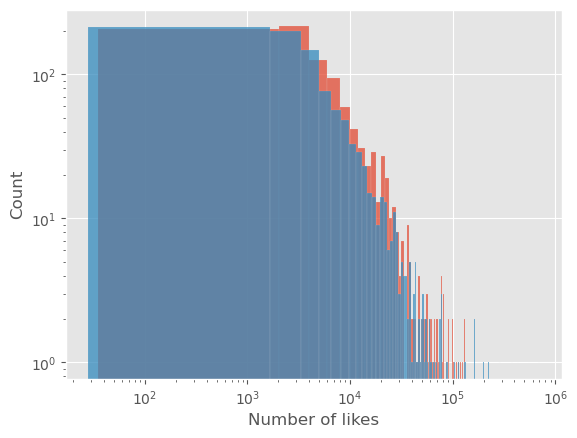

In [21]:
sns.histplot(data=sample_medians_sp)
sns.histplot(data=sample_median_nsp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of likes')

Here bootstrap sampling is useful to avoid unbalanced dataset sponsored vs not sponsored! ,,, TODO 

In [20]:
# subfig of distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# like_count is_sponsored hue
sns.histplot(data=all_metadatas.select('like_count', 'is_sponsored').toPandas(), x='like_count', hue='is_sponsored', ax=ax1)

KeyboardInterrupt: 

### Agencies vs Sponsors